# Dynamic Mode Decomposition

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
import random


# Ignore integration and solver convergence warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
import pysindy as ps
from optimalDMD import *
from variableProj import *

## Load and plot raw data

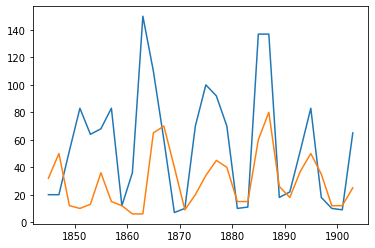

In [53]:
#LOAD DATA
t = np.linspace(1845,1903,30)[None,:]
SH = np.array([20,20,52,83,64,68,83,12,36,150,110,60,7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65])
CL = np.array([32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25])

SH = np.reshape(SH, (len(SH),1))
CL = np.reshape(CL, (len(CL),1))

X = (np.concatenate((SH,CL), axis=1)).T

plt.figure()
plt.plot(t[0,:], X[0,:])
plt.plot(t[0,:], X[1,:])

## Dynamic mode decomposition without bagging and without time delay

stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
[0.006245+0.0351142j 0.006245-0.0351142j]


/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x.append(np.linalg.lstsq(A,b)[0])
/Users/leonardoiacussi/opt/anaconda3/envs/tf_10/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  djacout,jpvt,tau,_,_=sci.linalg.lapack.zgeqp3(djacmat,work)
/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:148: ComplexWarning: Casting complex values to real discards the imagina

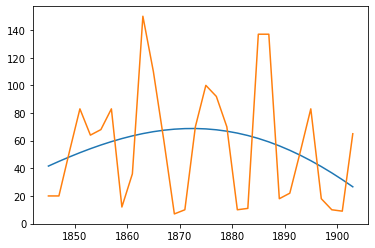

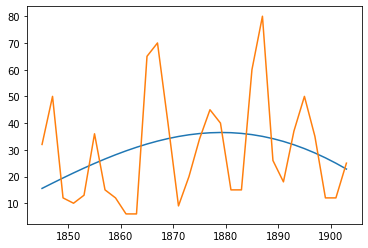

In [54]:
r=2
imode=1

alpha_init = np.array([-0.0001+0.05j , -0.0001-0.05j])
opts=varpro_opts(lambda0=1, maxlam=30,lamup=10, lamdown=10, maxiter=50,tol=1e-6,eps_stall=1e-12)
opts = varpro_opts()
w,e,b=optdmd(X,t,r,imode, custom_alpha_init = True, alpha_init_input=alpha_init, opts_from_main=True, opts=opts)

print(e)
e = np.reshape(e,(len(e),1))
X_build = w @ np.diag(b) @ np.exp(e*t)

plt.figure()
plt.plot(t[0,:],X_build[0,:])
plt.plot(t[0,:], SH)

plt.figure()
plt.plot(t[0,:],X_build[1,:])
plt.plot(t[0,:], CL)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## DmD with Bagging

In [62]:
n = t.shape[1]                                      # total number of points
k=27                                               # number of point choosen for bagging

r=2
imode=2
number_of_bagging =  500                          # number of times for bagging
                             
e_total = np.zeros((r,number_of_bagging),dtype = 'complex')
b_total = np.zeros((r,number_of_bagging))
w_total = np.zeros((r,r,number_of_bagging),dtype = 'complex')

time_series_matrix = np.zeros((2,n,number_of_bagging))

# generate a list of indexes for bagging
list = np.linspace(0,29,30)
list = list.astype(int)
list = list.tolist()

alpha_init = np.array([-0.0001+0.05j , -0.0001-0.05j])
opts=varpro_opts(lambda0=1e6, maxlam=30,lamup=10, lamdown=10, maxiter=50,tol=1e-6,eps_stall=1e-12)

for ii in range(number_of_bagging):
    # randmply select the k indexes for bagging
    pick_up_list = (random.sample(list,k))
    pick_up_list = np.sort(pick_up_list)
    t_reduced = t[:,pick_up_list]
    X_reduced = X[:,pick_up_list]

    # calculate the optimal DmD
    w,e,b=optdmd(X_reduced,t_reduced,r,imode,custom_alpha_init = True, alpha_init_input=alpha_init, opts_from_main=True, opts=opts)

    # sort eigen values and eigen vectors
    sort_indexes = np.argsort(np.imag(e))

    e = e[sort_indexes]
    w = w[:,sort_indexes]
    b = b[sort_indexes]

    e_total[:,ii] = e
    b_total[:,ii] = b
    w_total[:,:,ii] = w

    e = np.reshape(e,(len(e),1))
    time_series_matrix[:,:,ii] = w @ np.diag(b) @ np.exp(e*t)


/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x.append(np.linalg.lstsq(A,b)[0])
/Users/leonardoiacussi/opt/anaconda3/envs/tf_10/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  djacout,jpvt,tau,_,_=sci.linalg.lapack.zgeqp3(djacmat,work)
/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:148: ComplexWarning: Casting complex values to real discards the imagina

stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall detected: residual reduced by less than {:} 
 times residual at previous step. 
 iteration {:} 
 current residual {:}
stall de

### Plot eigen values and average eigen values

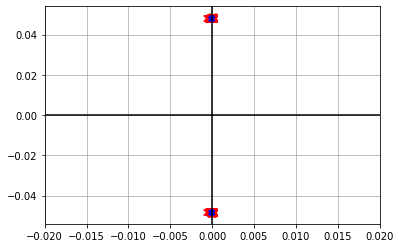

In [56]:
e_avg = np.mean(e_total, axis = 1)
w_avg = np.mean(w_total, axis = 2)
b_avg = np.mean(b_total, axis = 1)

for jj in range(r):
    for ii in range(e_total.shape[1]):
        plt.plot(np.real(e_total[jj,ii]),np.imag(e_total[jj,ii]),'rx')

    plt.plot(np.real(e_avg[jj]),np.imag(e_avg[jj]),'bX')


plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim([-0.02, 0.02])
plt.grid()

### plot reconstructed function

/Users/leonardoiacussi/opt/anaconda3/envs/tf_10/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/leonardoiacussi/opt/anaconda3/envs/tf_10/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


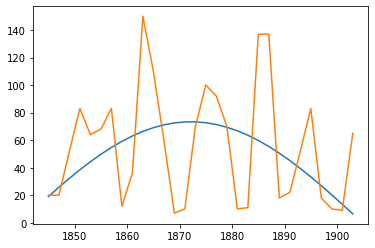

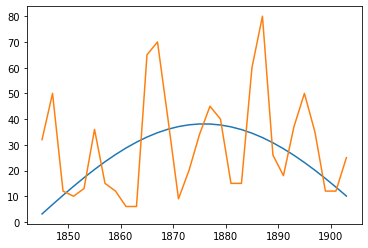

In [57]:
e_avg = np.reshape(e_avg,(len(e_avg),1))
X_build_bag =  w_avg @ np.diag(b_avg) @ np.exp(e_avg*t)

plt.figure()
plt.plot(t[0,:],X_build_bag[0,:])
plt.plot(t[0,:], SH)

plt.figure()
plt.plot(t[0,:],X_build_bag[1,:])
plt.plot(t[0,:], CL)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Time delay DmD

In [73]:
number_of_time_delays = 2
X_time_delays = np.zeros(((number_of_time_delays+1)*2,n-number_of_time_delays))

SH = np.reshape(SH,(1,n))
CL = np.reshape(CL,(1,n))

t_time_delays = t[:,0:-number_of_time_delays]
print(t_reduced.shape)
for ii in range(number_of_time_delays+1):
    X_time_delays[ii,:] = SH[:,ii:n-number_of_time_delays+ii]
    X_time_delays[ii+number_of_time_delays+1,:] = CL[:,ii:n-number_of_time_delays+ii]


(1, 28)


In [74]:
print(X_time_delays.shape)
print(t_time_delays.shape)

(6, 28)
(1, 28)


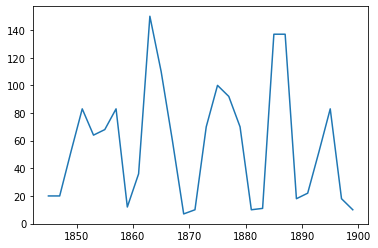

In [75]:
plt.plot(t_time_delays[0,:],X_time_delays[0,:])

In [85]:
r=6
imode=1

alpha_init = np.array([0.0001 + 0.6j , 0.0001 - 0.6j , 0.0001 + 0.05j , 0.0001 - 0.05j , 0.0001 + 0.75j , 0.0001 - 0.75j]).T
#opts=varpro_opts(lambda0=1, maxlam=30,lamup=10, lamdown=10, maxiter=50,tol=1e-6,eps_stall=1e-12)
#opts = varpro_opts()
w,e,b=optdmd(X_time_delays,t_time_delays,r,imode, custom_alpha_init = False, alpha_init_input=alpha_init, opts_from_main=True, opts=opts)

print(e)
e = np.reshape(e,(len(e),1))
X_build = w @ np.diag(b) @ np.exp(e*t)


/Users/leonardoiacussi/Modeling-from-Measurements/DmD/variableProj.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x.append(np.linalg.lstsq(A,b)[0])
/Users/leonardoiacussi/opt/anaconda3/envs/tf_10/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


ValueError: shapes (6,4) and (6,6) not aligned: 4 (dim 1) != 6 (dim 0)

/Users/leonardoiacussi/opt/anaconda3/envs/tf_10/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


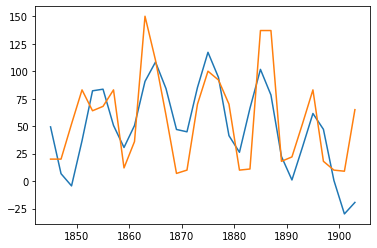

In [82]:
plt.figure()
plt.plot(t[0,:],X_build[0,:])
plt.plot(t[0,:],SH[0,:])